In [1]:
import ast
import copy
import numpy as np
from numpy import linalg
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import networkx as nx

In [2]:
def plotFMI(G, save_path=None):
    coords = np.array([G.nodes[node]['coord'] for node in G.nodes]) # 'coord' (tuple: latitude, longitude) for spatial positioning.

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(coords[:, 1], coords[:, 0], c='black', s=50, zorder=5)
    for node, (lat, lon) in enumerate(coords):
        ax.text(lon + 0.1, lat + 0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    for u, v in G.edges:
        ax.plot([coords[u, 1], coords[v, 1]], [coords[u, 0], coords[v, 0]], linestyle='-', color='gray')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('FMI Stations Colored by Cluster')
    ax.set_aspect(1.6)
    
    if save_path != None:
        try:
            plt.savefig(save_path)
        except: 
            print("The plot cannot be saved. The path is invalid. ")
            
    plt.show()
    
def add_edges(G, numneighbors=4):
    # Avoid modifying the original
    graph_with_edges = copy.deepcopy(G)

    coords = np.array([graph_with_edges.nodes[node]['coord'] for node in graph_with_edges.nodes])

    # Create adjacency matrix using k-nearest neighbors
    adjacency_matrix = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)

    edges = zip(*adjacency_matrix.nonzero())
    graph_with_edges.add_edges_from(edges)

    return graph_with_edges

In [3]:
'''
fmi_data_2025.csv

- Name: The name of the weather station
- Latitude: The latitude of the weather station
- Longitude: The longitude of the weather station
- Tmax: The highest temperature recorded in the past five days
- Tmin: The lowest temperature recorded in the past five days
- y_Tmax: The highest temperature during a specific day
- y_Tmin: The lowest temperature during a specific day

Use `Tmax` and `Tmin` to predict `y_Tmax`.
'''

data = pd.read_csv('fmi_data_2025.csv')

# Create a new column 'X' that combines Tmax and Tmin values for each station
data['X'] = data.apply(lambda row: row['Tmax'] + row['Tmin'], axis=1)
data['X'] = data['X'].apply(lambda row: ast.literal_eval(row.replace('][', ', ')))

n_stations = len(data.Name.unique())
print(f"Number of unique stations: {n_stations}")

print(data.head())

Number of unique stations: 192
                              Name  Latitude  Longitude  \
0  Jomala Maarianhamina lentoasema  60.12735   19.90038   
1  Jomala Maarianhamina lentoasema  60.12735   19.90038   
2  Jomala Maarianhamina lentoasema  60.12735   19.90038   
3  Jomala Maarianhamina lentoasema  60.12735   19.90038   
4  Jomala Maarianhamina lentoasema  60.12735   19.90038   

                          Tmax                            Tmin  y_Tmax  \
0  [0.3, -1.9, -1.2, 5.4, 7.7]   [-2.6, -4.9, -5.1, -9.6, 4.4]     7.1   
1    [6.4, 4.6, 3.1, 5.9, 6.3]      [4.4, 2.2, -1.5, 3.0, 5.1]     5.8   
2   [4.7, -2.1, 3.2, 4.5, 4.0]   [-2.6, -9.1, -9.2, -0.7, 0.5]     2.7   
3    [2.7, 0.9, 4.2, 2.7, 1.1]  [-3.4, -4.2, -2.1, -3.7, -7.8]     3.7   
4    [2.4, 5.8, 4.5, 4.8, 6.4]    [-2.0, -0.2, 2.5, -5.6, 3.6]     4.7   

   y_Tmin                                                  X  
0     5.7  [0.3, -1.9, -1.2, 5.4, 7.7, -2.6, -4.9, -5.1, ...  
1     4.0  [6.4, 4.6, 3.1, 5.9, 6.3, 4.4, 2

### Task 1: Building a FMI Network

In [4]:
G_FMI_no_edges = nx.Graph()

G_FMI_no_edges.add_nodes_from(range(0, n_stations))

for i, station in enumerate(data.Name.unique()):

    station_data = data[data.Name==station]
    X_node = station_data['X'].to_numpy().reshape(-1, 1)
    y_node = station_data['y_Tmax'].to_numpy().reshape(-1, 1)
    X_train, X_val, y_train, y_val = train_test_split(X_node,
                                                      y_node, 
                                                      test_size=0.2, 
                                                      random_state=42)

    G_FMI_no_edges.nodes[i].update({
        'name': station,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'weights': np.zeros((X_node.shape[1], 1)),
        'coord': (station_data.Latitude.iloc[0], station_data.Longitude.iloc[0])
    })

# Add edges between each station and its nearest 4 neighbors.
G_FMI = add_edges(G_FMI_no_edges, numneighbors=4)
print("The empirical graph is connected:", nx.is_connected(G_FMI))

The empirical graph is connected: True


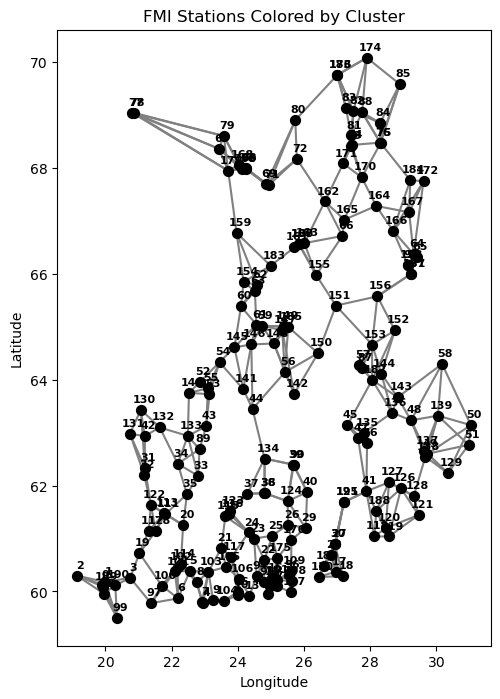

In [5]:
for node in G_FMI.nodes:
    X_train_obj = G_FMI.nodes[node]['X_train'] 
    X_train_array = np.array([row[0] for row in X_train_obj], dtype=float)
    G_FMI.nodes[node]['X_train'] = X_train_array
    
    X_val_obj = G_FMI.nodes[node]['X_val'] 
    X_val_array = np.array([row[0] for row in X_val_obj], dtype=float)
    G_FMI.nodes[node]['X_val'] = X_val_array

plotFMI(G_FMI)

In [6]:
attributes = set(G_FMI.nodes[0].keys())
assert (set(['name', 'X_train', 'y_train', 'X_val', 'y_val', 'weights', 'coord']) == attributes), 'Some attributes have not been found!'

assert(G_FMI.number_of_nodes() == 192), "Should have 192 nodes"
assert(G_FMI.number_of_edges() == 486), "Should have 486 edges with neighbors=4"
assert([np.all(G_FMI.nodes[i]['X_train'].shape == (8,10) for i in range(G_FMI.number_of_nodes()))]), "X_train shape for each node should be (8,10)"
assert([np.all(G_FMI.nodes[i]['X_val'].shape == (2,10) for i in range(G_FMI.number_of_nodes()))]), "X_val shape for each node should be (2,10)"
assert([np.all(G_FMI.nodes[i]['y_train'].shape == (8,1) for i in range(G_FMI.number_of_nodes()))]), "y_train shape for each node should be (8,1)"
assert([np.all(G_FMI.nodes[i]['y_val'].shape == (2,10) for i in range(G_FMI.number_of_nodes()))]), "y_val shape for each node should be (2,10)"

assert([np.all(G_FMI.nodes[i]['X_train'].dtype == np.float64 for i in range(G_FMI.number_of_nodes()))]), "data type should be float64"
assert([np.all(G_FMI.nodes[i]['y_train'].dtype == np.float64 for i in range(G_FMI.number_of_nodes()))]), "data type should be float64"
assert([np.all(G_FMI.nodes[i]['X_val'].dtype == np.float64 for i in range(G_FMI.number_of_nodes()))]), "data type should be float64"
assert([np.all(G_FMI.nodes[i]['y_val'].dtype == np.float64 for i in range(G_FMI.number_of_nodes()))]), "data type should be float64"

test_node = G_FMI.nodes[57]
assert (test_node['name'] == 'Kajaani lentoasema')
assert np.all(test_node['X_train'] == np.array([
    [ -4.1,  -3.7,  -2.3,  -2.2,   3.1, -10.5, -10.2,  -7.4,  -6.7, -6.1],
    [ -3.6,  -2. ,  -2.7,  -1.1,   5.9,  -8.2,  -4.5,  -4.3,  -4.1, -2.8],
    [ -7.7,  -7.4, -10.1, -14.3, -10. , -12.4, -10.1, -14.5, -26. , -20.8],
    [  0.5,  -5. ,  -6.8,  -1.4,  -1.3,  -5. , -11.6,  -9.8,  -6.8, -3.7],
    [  2.9,   0.5,   5.6,   4.2,   5. ,  -2.5, -13.8,  -1.9,  -0.8, -1.4],       
    [-13. , -12. , -13.4, -15.3,  -7.2, -21.9, -15.2, -24.1, -24.8, -22.4],
    [ -0.1,   2.7,   3.1,  -2.8,  -7.9,  -5.9,  -2.2,  -3.1,  -8.1, -15.7],
    [  2.1,   0.5,   2. ,   1.3,  -0.4,  -0.6,  -4.2,  -4.9,  -3.2, -4.2]]))
assert np.all(test_node['y_train'] == np.array([
    [  4. ], [  6. ], [ -9.8], [ -1.5], [  4.4], [ -4.1], [-11.9], [ -3. ]]))
assert np.all(test_node['X_val'] == np.array([
    [ -7.3,  -6.7, -12.9, -15.3, -11.7,  -9.7, -12.9, -25.1, -25.6, -27.4],
    [  4.9,   1.2,   1.1,   0.3,   4. ,   0.6,   0.5,  -1. ,  -6.8, -1.1]]))
assert np.all(test_node['y_val'] == np.array([[-2.4], [ 6.3]]))
assert np.all(test_node['weights'] == np.array([[0.]]))
assert (test_node['coord'] == (64.2829, 27.67114))
assert set([neighbor for neighbor in G_FMI.neighbors(57)]) == set([87, 182, 153, 144])

### Task 2: Solve GTVMin using closed form

In [9]:
def compute_Qi(X):
    # Q^(i) = (1 / m_i) * X^T * X
    m_i = X.shape[0]
    return (1/m_i) * (X.T @ X)

def compute_qi(X, y):
    # q^(i) = (-2 / m_i) * X^T * y
    m_i = X.shape[0]
    return (-2/m_i) * (X.T @ y)

In [11]:
X_train_0 = G_FMI.nodes[0]['X_train']
y_train_0 = G_FMI.nodes[0]['y_train']

Qi_0 = compute_Qi(X_train_0)
qi_0 = compute_qi(X_train_0, y_train_0)

assert(Qi_0.shape == (10,10))
assert(qi_0.shape == (10,1))

Qi_ref = compute_Qi(X_train_0)
qi_ref = compute_qi(X_train_0, y_train_0)

np.testing.assert_array_almost_equal_nulp(Qi_ref, Qi_0, nulp=1)
np.testing.assert_array_almost_equal_nulp(qi_ref, qi_0, nulp=1)

In [12]:
def compute_stack_Qi_q(G):

    nodes = list(G.nodes)

    Qi_blocks = [] # A block diagonal matrix of shape (n*d, n*d) where each Q^(i) is placed along the diagonal
    q_blocks = [] # A stacked column vector of shape (n*d, 1) where each q^(i) is vertically stacked

    for node in nodes:
        X = G.nodes[node]['X_train']  # (m_i, d)
        y = G.nodes[node]['y_train']  # (m_i,)
        Q_i = compute_Qi(X)
        q_i = compute_qi(X, y).reshape(-1, 1) 

        Qi_blocks.append(Q_i)
        q_blocks.append(q_i)

    Qi_blockdiag = block_diag(*Qi_blocks)  # shape: (n*d, n*d)
    q_stacked = np.vstack(q_blocks)      # shape: (n*d, 1)

    return Qi_blockdiag, q_stacked
    
def compute_Q(G, Qi_blockdiag, alpha=1):

    d = G.nodes[0]['X_train'].shape[1]
    
    L = nx.laplacian_matrix(G).toarray()

    I_d = np.eye(d)  

    L_kron_I = np.kron(L, I_d) # L ⊗ I_d: (n*d) x (n*d)

    Q = Qi_blockdiag + alpha * L_kron_I # A matrix of shape (n*d, n*d) computed as Q_blockdiag + alpha * (L ⊗ I_d).
    
    return Q

In [13]:
Qi_blockdiag, q_stacked= compute_stack_Qi_q(G_FMI)

Q = compute_Q(G_FMI, Qi_blockdiag, alpha=1)

def compute_stack_Qi_q_ref(G):
    nodes = list(G.nodes)
    Qi_blocks = []
    q_blocks = []
    for node in nodes:
        X = G.nodes[node]['X_train']  
        y = G.nodes[node]['y_train']  
        Q_i = compute_Qi(X)
        q_i = compute_qi(X, y).reshape(-1, 1) 
        Qi_blocks.append(Q_i)
        q_blocks.append(q_i)
    Qi_blockdiag = block_diag(*Qi_blocks)  
    q_stacked = np.vstack(q_blocks)  
    return Qi_blockdiag, q_stacked
    
def compute_Q_ref(G, Qi_blockdiag, alpha=1):
    d = G.nodes[0]['X_train'].shape[1]
    L = nx.laplacian_matrix(G).toarray() 
    I_d = np.eye(d)  
    L_kron_I = np.kron(L, I_d)
    Q = Qi_blockdiag + alpha * L_kron_I
    return Q

Qi_blockdiag_ref, q_stacked_ref = compute_stack_Qi_q_ref(G_FMI)
Q_ref = compute_Q_ref(G_FMI, Qi_blockdiag_ref, alpha=1)

np.testing.assert_array_almost_equal_nulp(Qi_blockdiag_ref, Qi_blockdiag, nulp=1)
np.testing.assert_array_almost_equal_nulp(q_stacked_ref, q_stacked, nulp=1)
np.testing.assert_array_almost_equal_nulp(Q_ref, Q, nulp=1)

In [14]:
def compute_w(Q, q):
    x = np.linalg.solve(Q, q)
    w_hat = (-0.5) * x
    
    return w_hat

w_hat = compute_w(Q, q_stacked)

def compute_w_ref(Q, q):
    x = np.linalg.solve(Q, q)
    w_hat = (-0.5) * x
    return w_hat

w_hat_ref = compute_w_ref(Q_ref, q_stacked_ref)

np.testing.assert_array_almost_equal_nulp(w_hat_ref, w_hat, nulp=1)

### Task 3: Solve GTVMin using gradient

In [15]:
def fedgd_linear(graph, alpha=1.0, eta=0.001, max_iter=100):    
    """
    Perform Federated Gradient Descent (FedGD) on a graph G for a linear model.

    This function iteratively updates local model weights for each node in the graph 
    using Mean Squared Error (MSE) gradient descent. It also incorporates a graph-based 
    penalty term to encourage similar weights among neighboring nodes.

    alpha : float, optional
        Regularization parameter for the neighbor penalty (default is 1.0).
    eta : float, optional
        Learning rate for gradient updates (default is 0.001).
    max_iter : int, optional
        Number of gradient descent iterations (default is 100).
    """

    np.random.seed(42)

    G = copy.deepcopy(graph)

    for node in G.nodes():
        d = (10,1)
        w_init = np.random.uniform(low=-1.0, high=1.0, size=d)
        G.nodes[node]['w'] = w_init # Initialized model weights (randomized)

    for _ in range(max_iter):
        w_new = {}

        # Compute updates for each node
        for node in G.nodes():
            w_i_k = G.nodes[node]['w']

            X_train = G.nodes[node]['X_train']
            y_train = G.nodes[node]['y_train']
            
            # Local gradient
            m_i = X_train.shape[0]
            residual = y_train - X_train @ w_i_k
            grad_local = (2.0 / m_i) * (X_train.T @ residual)

            # Graph penalty
            grad_graph = np.zeros_like(w_i_k)
            for nbr in G.neighbors(node):
                w_j_k = G.nodes[nbr]['w']
                grad_graph += (w_j_k - w_i_k)
            grad_graph *= 2.0 * alpha

            grad_total = -(grad_local + grad_graph)

            w_i_next = w_i_k - eta * grad_total

            w_new[node] = w_i_next

        for node in G.nodes():
            G.nodes[node]['w'] = w_new[node]

    return G

In [16]:
alpha=1
eta=0.0001
max_iter=100

G_fedgd = fedgd_linear(
    G_FMI,
    alpha=alpha,
    eta=eta,
    max_iter=max_iter
)

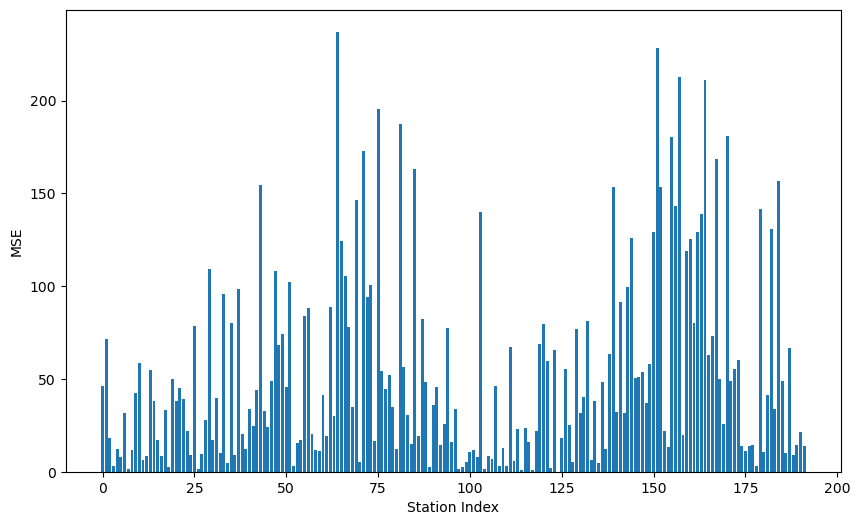

Average MSE: 53.22499740527876


In [17]:
mse_list = []
for node in G_fedgd.nodes():
    w_final = G_fedgd.nodes[node]['w']
    X_val_local = G_fedgd.nodes[node]['X_val']
    y_val_local = G_fedgd.nodes[node]['y_val']
    y_pred = X_val_local @ w_final
    mse = mean_squared_error(y_val_local, y_pred)
    mse_list.append(mse)

plt.figure(figsize=(10, 6))
plt.bar(range(len(mse_list)), mse_list)
plt.xlabel('Station Index')
plt.ylabel('MSE')
plt.show()

avg_mse = np.mean(mse_list)
print("Average MSE:", avg_mse)

In [18]:
def fedgd_linear_ref(graph, alpha=1.0, eta=0.001, max_iter=100):   
    np.random.seed(42) 
    G = copy.deepcopy(graph)
    for node in G.nodes():
        d = (10,1)
        w_init = np.random.uniform(low=-1.0, high=1.0, size=d)
        G.nodes[node]['w'] = w_init

    for _ in range(max_iter):
        w_new = {}
        for node in G.nodes():
            w_i_k = G.nodes[node]['w']
            X_train = G.nodes[node]['X_train']
            y_train = G.nodes[node]['y_train']
            m_i = X_train.shape[0] 
            residual = y_train - X_train @ w_i_k 
            grad_local = (2.0 / m_i) * (X_train.T @ residual)
            grad_graph = np.zeros_like(w_i_k)
            for nbr in G.neighbors(node):
                w_j_k = G.nodes[nbr]['w']
                grad_graph += (w_j_k - w_i_k)
            grad_graph *= 2.0 * alpha
            grad_total = -(grad_local + grad_graph)
            w_i_next = w_i_k - eta * grad_total
            w_new[node] = w_i_next
        for node in G.nodes():
            G.nodes[node]['w'] = w_new[node]
    return G

G_fedgd_ref = fedgd_linear_ref(
    G_FMI,
    alpha=alpha,
    eta=eta,
    max_iter=max_iter
)

w_final_82 = G_fedgd.nodes[82]['w']
w_final_82_ref = G_fedgd_ref.nodes[82]['w']

np.testing.assert_array_almost_equal_nulp(w_final_82_ref, w_final_82, nulp=1)